In [20]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('figure', figsize=(15, 10))

import qcodes as qc
%matplotlib notebook


In [3]:
import qcodes.instrument_drivers.rohde_schwarz.ZNB as ZNB
vna = ZNB.ZNB('VNA', 'GPIB0::29::INSTR', init_s_params=False)

Connected to: Rohde-Schwarz ZNB8-2Port (serial:1311601042103823, firmware:1.70) in 0.14s


# Measuring one trace (linear magnitude and phase)

In [4]:
# set up the VNA
vna.clear_channels()
vna.add_channel('S21')
vna.channels.S21.power(-30)
vna.rf_on()

vna.channels.S21.format('dB') # just for the screen

vna.channels.S21.start(3e9)
vna.channels.S21.stop(3.06e9)
vna.channels.S21.npts(500)
vna.channels.S21.bandwidth(1e2)
vna.channels.S21.avg(1)

In [4]:
data = qc.Measure(vna.channels.S21.trace_mag_phase).run()

DataSet:
   location = 'data/2018-02-22/#008_{name}_16-20-13'
   <Type>   | <array_id>        | <array.name>  | <array.shape>
   Setpoint | S21_frequency_set | S21_frequency | (500,)
   Measured | VNA_S21_magnitude | magnitude     | (500,)
   Measured | VNA_S21_phase     | phase         | (500,)
acquired at 2018-02-22 16:20:18


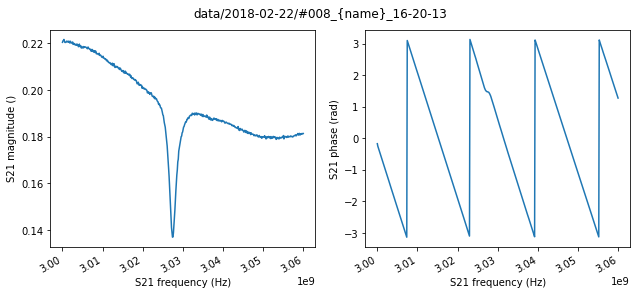

In [13]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

plot = qc.MatPlot(subplots=2)

plot.add(data.VNA_S21_magnitude, subplot=1)
plot.add(data.VNA_S21_phase, subplot=2)

plot.tight_layout()

fig = plot.fig

for subplot in fig.axes:
    #subplot.xaxis.set_major_formatter(FormatStrFormatter('%.03e'))
    for label in subplot.get_xmajorticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment("right")

## Conversion from linear to dB scale

In [6]:
# show with log magnitude

log_magnitude = 20*np.log10(np.array(data.VNA_S21_magnitude))

data.add_array(qc.DataArray(preset_data=log_magnitude,name='log_magnitude',  array_id='log_magnitude', label="Magnitude", unit='dB'))


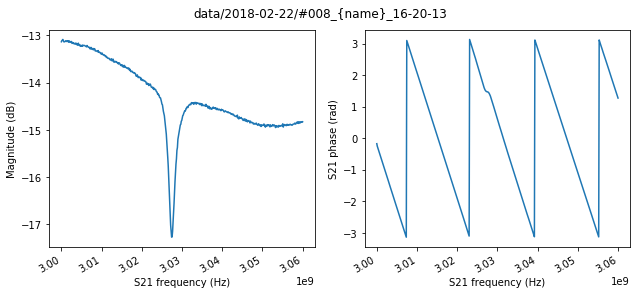

In [7]:
plot = qc.MatPlot(subplots=2)

plot.add(data.S21_frequency_set,data.log_magnitude, subplot=1)
plot.add(data.VNA_S21_phase, subplot=2)

plot.tight_layout()

fig = plot.fig

for subplot in fig.axes:
    #subplot.xaxis.set_major_formatter(FormatStrFormatter('%.03e'))
    for label in subplot.get_xmajorticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment("right")

# Fit the resonance with resonator_tools

[-3.96733545e-07  1.18997202e+03]


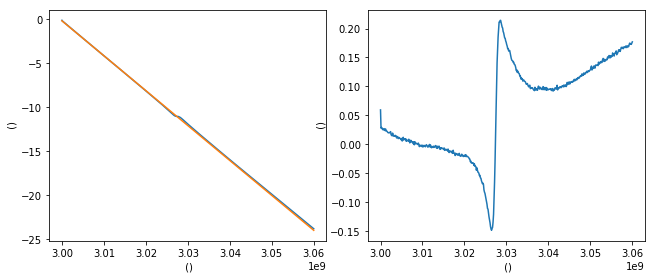

In [14]:
# background linear phase subtraction

phase = np.array(data.VNA_S21_phase)
phase = np.unwrap(phase)
freq = np.array(data.S21_frequency_set)

range_i = range(0,250)
coeffs = np.polyfit(freq[range_i], phase[range_i], 1)
print(coeffs)
fitted_line = np.polyval(coeffs,freq)
phase_corrected = phase - fitted_line

plot = qc.MatPlot(subplots=2)

plot.add(freq,phase, subplot=1)
plot.add(freq,fitted_line, subplot=1)
plot.add(freq,phase_corrected, subplot=2)

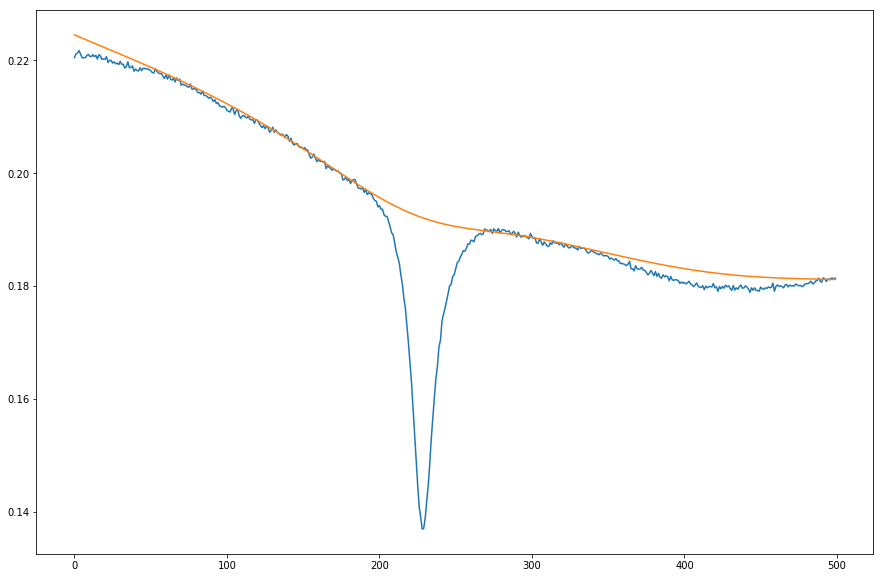

In [15]:
from resonator_tools import circuit

complex_S = np.array(data.VNA_S21_magnitude)*np.exp(1j*phase_corrected)

port1 = circuit.reflection_port(f_data=freq,
                                z_data_raw=complex_S)

lam = 1e5 #smoothness
p = 0.99  #asymmetry
fitted_baseline = port1.fit_baseline_amp(port1.z_data_raw,lam,p,niter=100)

plt.plot()

plt.plot(np.absolute(port1.z_data_raw))
plt.plot(fitted_baseline)

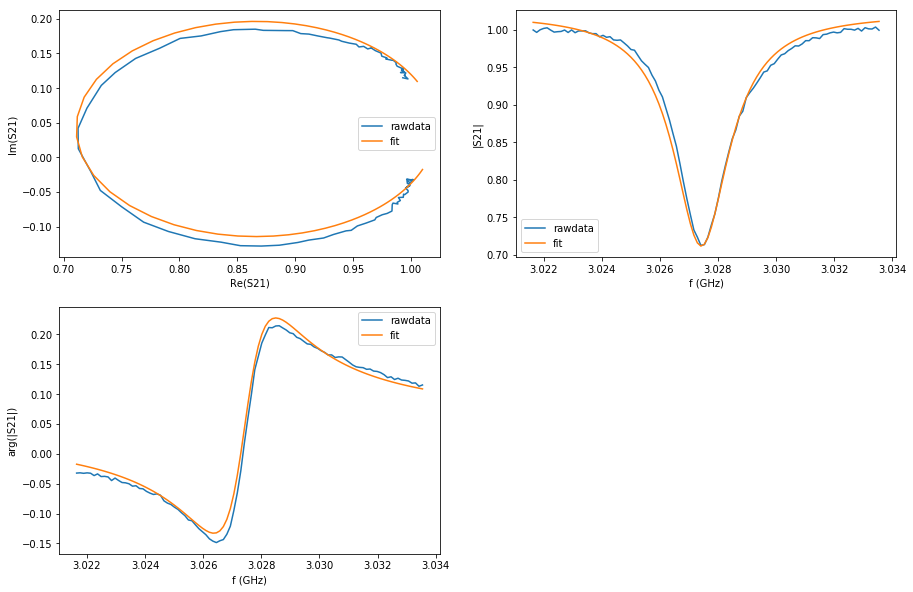

In [27]:
indices = range(180,280)


port2 = circuit.reflection_port(f_data=freq[indices],z_data_raw=(complex_S/(fitted_baseline))[indices]) 

port2.autofit()
port2.plotall()

In [28]:
port2.fitresults

{'Qc': 7820.0118855894925,
 'Qc_err': 141.95899738102204,
 'Qi': 1400.5840910043667,
 'Qi_err': 37.47617751661265,
 'Ql': 1187.8390796239669,
 'Ql_err': 29.14919182800683,
 'chi_square': 0.00018838017775076426,
 'fr': 3027431749.86331,
 'fr_err': 18609.490291737737,
 'theta0': 0.059511869979530396}

# 2D maps

## Power vs. frequency map

In [45]:
# without realtime plotting

vna.channels.S21.start(3.01e9)
vna.channels.S21.stop(3.05e9)
vna.channels.S21.npts(100)
vna.channels.S21.bandwidth(1e2)
vna.channels.S21.avg(1)

data_map = qc.Loop(vna.channels.S21.power.sweep(-50,-30,2)).each(vna.channels.S21.trace_mag_phase).run()

Started at 2018-02-22 17:37:54
DataSet:
   location = 'data/2018-02-22/#014_{name}_17-37-54'
   <Type>   | <array_id>        | <array.name>  | <array.shape>
   Setpoint | VNA_S21_power_set | power         | (11,)
   Setpoint | S21_frequency_set | S21_frequency | (11, 100)
   Measured | VNA_S21_magnitude | magnitude     | (11, 100)
   Measured | VNA_S21_phase     | phase         | (11, 100)
Finished at 2018-02-22 17:38:06


<IPython.core.display.Javascript object>


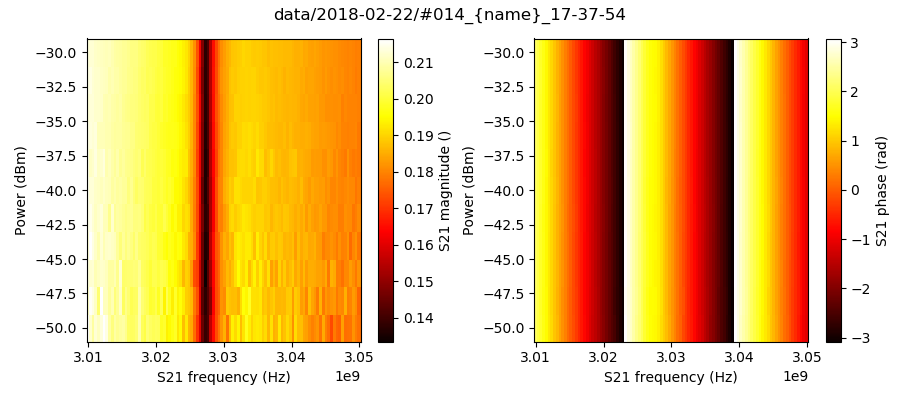

In [51]:
# measurement is done, now we plot the result

plot = qc.MatPlot(subplots=2)
plot.add(data_map.VNA_S21_magnitude, subplot=1)
plot.add(data_map.VNA_S21_phase, subplot=2)

plot.tight_layout()

<IPython.core.display.Javascript object>


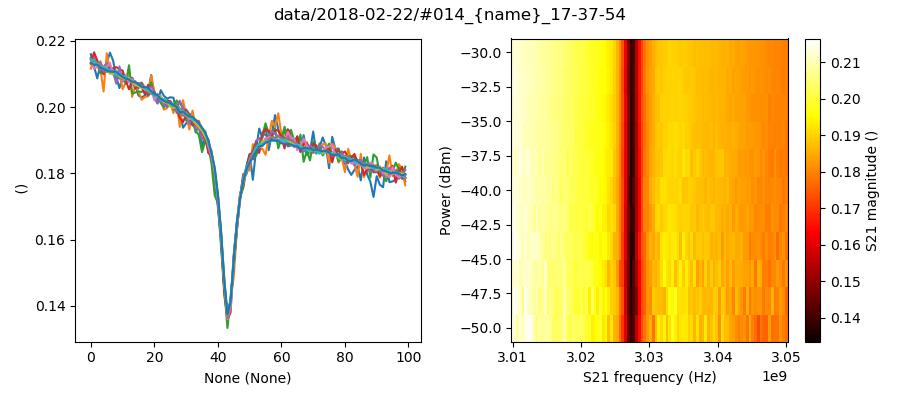

<IPython.core.display.Javascript object>


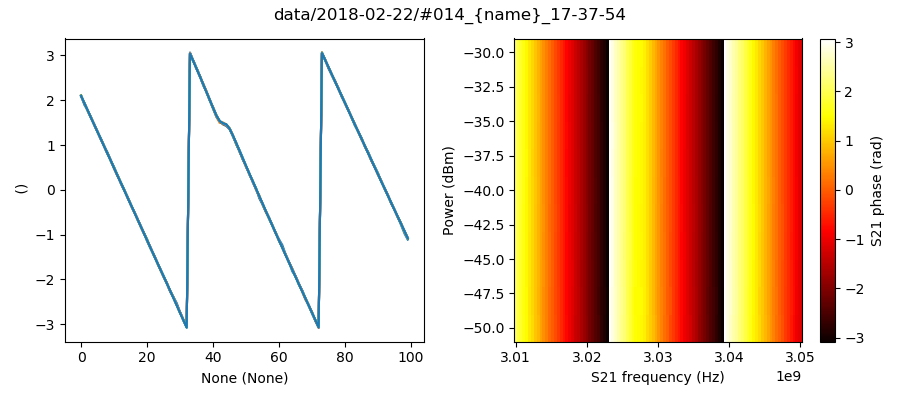

In [53]:
# plot with trace cuts

plot = qc.MatPlot([*data_map.VNA_S21_magnitude], data_map.VNA_S21_magnitude)
plot = qc.MatPlot([*data_map.VNA_S21_phase], data_map.VNA_S21_phase)

plot.tight_layout()


<IPython.core.display.Javascript object>


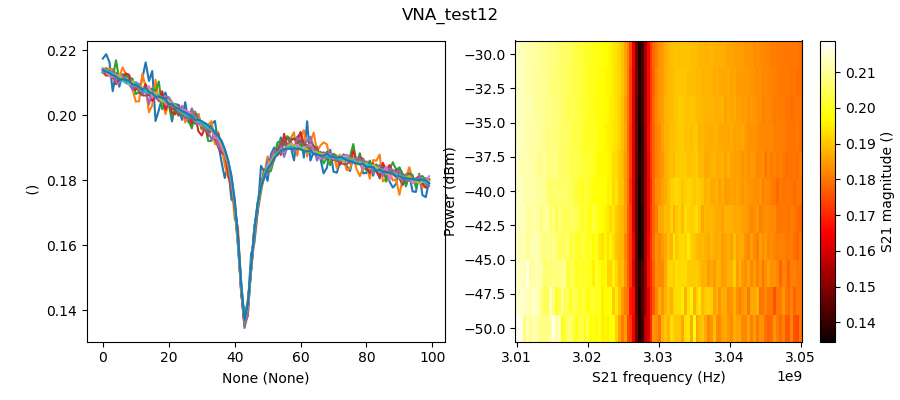

Started at 2018-02-22 17:41:16


C:\Users\meso\Anaconda3\envs\qcodes\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
C:\Users\meso\Anaconda3\envs\qcodes\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


DataSet:
   location = 'VNA_test12'
   <Type>   | <array_id>        | <array.name>  | <array.shape>
   Setpoint | VNA_S21_power_set | power         | (11,)
   Setpoint | S21_frequency_set | S21_frequency | (11, 100)
   Measured | VNA_S21_magnitude | magnitude     | (11, 100)
   Measured | VNA_S21_phase     | phase         | (11, 100)
Finished at 2018-02-22 17:41:30


In [60]:
# realtime plotting, trace by trace (important: %matplotlib notebook)
# todo: plot phase realtime as well?
loop = qc.Loop(
    vna.channels.S21.power.sweep(-50,-30,2),delay=0.05).each(
            vna.channels.S21.trace_mag_phase)

data_map = loop.get_data_set('VNA_test12')

# Create plot for measured data
plot = qc.MatPlot([*data_map.VNA_S21_magnitude], data_map.VNA_S21_magnitude)

# Attach updating of plot to loop
loop.with_bg_task(plot.update)

loop.run();

In [26]:
from qcodes.instrument_drivers.unibasel.SP927 import SP927

dac = SP927("DAC","ASRL4::INSTR")


Connected to: ? None (serial:None, firmware:None) in 0.04s


In [37]:
dac.ch8.volt.inter_delay=0.01
dac.ch8.volt.step=0.001

In [39]:
dac.ch8.volt.set(0.1)

In [40]:
dac.ch8.volt.get()

0.10000023842221673

In [41]:
dac.ch8.volt.set(0)

In [42]:
dac.ch8.volt.get()

0.0

## Frequency vs. gate voltage (DAC)

<IPython.core.display.Javascript object>


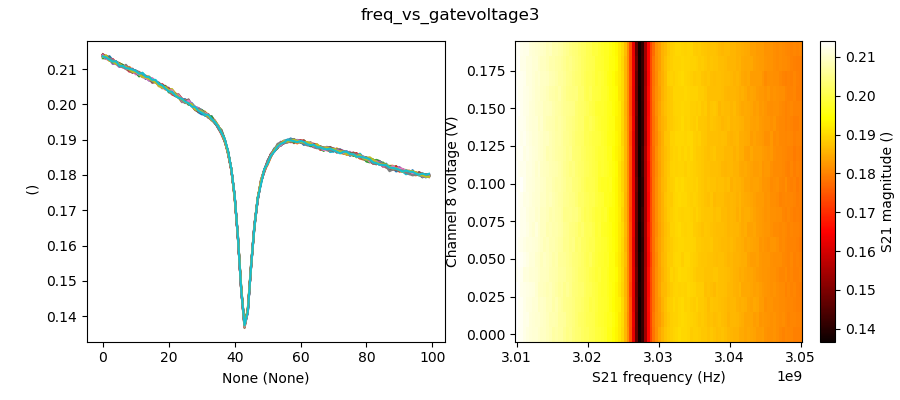

Started at 2018-02-22 17:42:47


C:\Users\meso\Anaconda3\envs\qcodes\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
C:\Users\meso\Anaconda3\envs\qcodes\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


DataSet:
   location = 'freq_vs_gatevoltage3'
   <Type>   | <array_id>         | <array.name>  | <array.shape>
   Setpoint | DAC_chan8_volt_set | volt          | (20,)
   Setpoint | S21_frequency_set  | S21_frequency | (20, 100)
   Measured | VNA_S21_magnitude  | magnitude     | (20, 100)
   Measured | VNA_S21_phase      | phase         | (20, 100)
Finished at 2018-02-22 17:43:22


In [62]:
# realtime plotting, trace by trace (important: %matplotlib notebook)

sweep_vals = dac.ch8.volt[0:0.2:0.01]

loop = qc.Loop(sweep_vals, delay=0.01).each(vna.channels.S21.trace_mag_phase)

data_map = loop.get_data_set('freq_vs_gatevoltage3')

# Create plot for measured data
plot = qc.MatPlot([*data_map.VNA_S21_magnitude], data_map.VNA_S21_magnitude)
# Attach updating of plot to loop
loop.with_bg_task(plot.update)

loop.run();

## Frequency vs magnetic field (with MercuryiPS)

In [63]:
from qcodes.instrument_drivers.oxford.mercuryiPS_VISA import MercuryiPS

magnet = MercuryiPS(name = 'Magnet', address='ASRL5::INSTR')

d:\git_sync\qcodes\qcodes\instrument\parameter.py:209: UserWarning: Wrapping get method, original get method will not be directly accessible. It is recommended to define get_raw in your subclass instead.
  warnings.warn('Wrapping get method, original get method will not '
d:\git_sync\qcodes\qcodes\instrument\parameter.py:216: UserWarning: Wrapping set method, original set method will not be directly accessible. It is recommended to define set_raw in your subclass instead.
  warnings.warn('Wrapping set method, original set method will not '
d:\git_sync\qcodes\qcodes\instrument\parameter.py:1097: UserWarning: MultiParameters do not support set at this time.
  warnings.warn('MultiParameters do not support set at this time.')


Connected to: IDN OXFORD INSTRUMENTS (serial:MERCURY IPS, firmware:NOT_FOUND:2.5.05.000) in 0.96s
Connected to: IDN OXFORD INSTRUMENTS (serial:MERCURY IPS, firmware:NOT_FOUND:2.5.05.000) in 1.05s
Connected to: IDN OXFORD INSTRUMENTS (serial:MERCURY IPS, firmware:NOT_FOUND:2.5.05.000) in 1.13s
Connected to: IDN OXFORD INSTRUMENTS (serial:MERCURY IPS, firmware:NOT_FOUND:2.5.05.000) in 1.21s


<IPython.core.display.Javascript object>


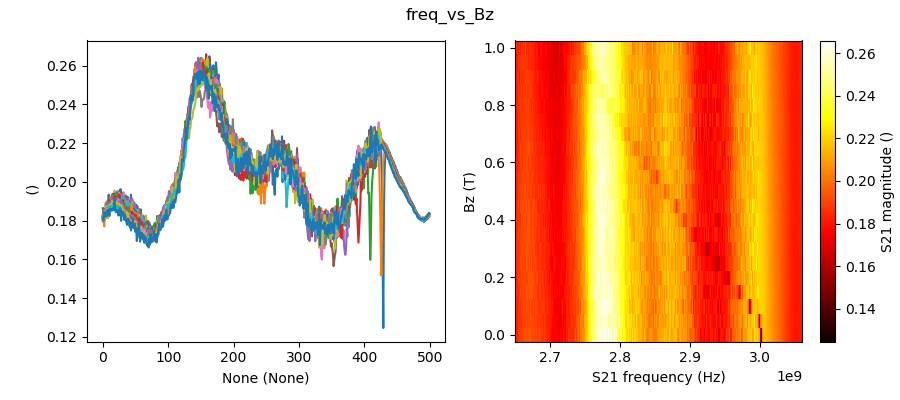

Started at 2018-02-23 12:17:50


C:\Users\meso\Anaconda3\envs\qcodes\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
C:\Users\meso\Anaconda3\envs\qcodes\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


DataSet:
   location = 'freq_vs_Bz'
   <Type>   | <array_id>        | <array.name>  | <array.shape>
   Setpoint | Magnet_z_fld_set  | z_fld         | (21,)
   Setpoint | S21_frequency_set | S21_frequency | (21, 500)
   Measured | VNA_S21_magnitude | magnitude     | (21, 500)
   Measured | VNA_S21_phase     | phase         | (21, 500)
Finished at 2018-02-23 12:44:14


In [67]:
# realtime plotting, trace by trace (important: %matplotlib notebook)

vna.channels.S21.power(-30)
vna.rf_on()

vna.channels.S21.format('dB') # just for the screen

vna.channels.S21.start(2.65e9)
vna.channels.S21.stop(3.06e9)
vna.channels.S21.npts(500)
vna.channels.S21.bandwidth(1e2)
vna.channels.S21.avg(1)

magnet.z_ACTN.set('HOLD') # set it to HOLD, because it was CLAMPED
loop = qc.Loop(magnet.z_fld.sweep(0,1,50e-3), delay=0.01).each(vna.channels.S21.trace_mag_phase)

data_map = loop.get_data_set('freq_vs_Bz')

# Create plot for measured data
plot = qc.MatPlot([*data_map.VNA_S21_magnitude], data_map.VNA_S21_magnitude)
# Attach updating of plot to loop
loop.with_bg_task(plot.update)

loop.run();

In [ ]:
magnet.z_rate.set(0.25)
magnet.z_fld.set(0)

<IPython.core.display.Javascript object>


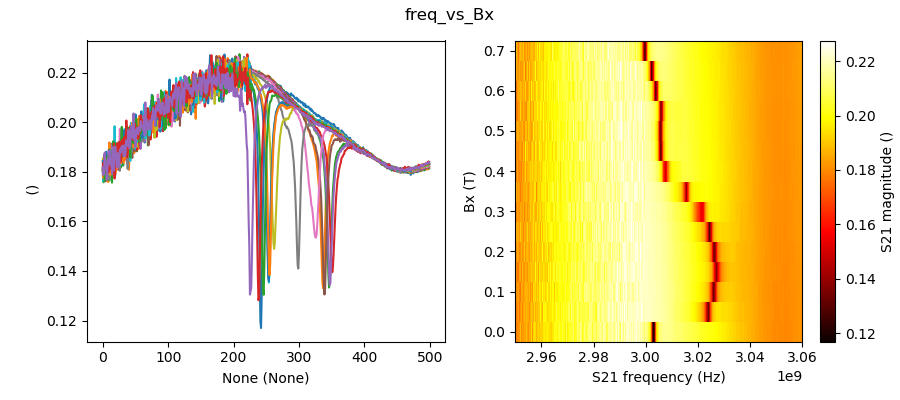

Started at 2018-02-23 16:15:10


C:\Users\meso\Anaconda3\envs\qcodes\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
C:\Users\meso\Anaconda3\envs\qcodes\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


In [ ]:
vna.channels.S21.start(2.95e9)
vna.channels.S21.stop(3.06e9)
vna.channels.S21.npts(500)
vna.channels.S21.bandwidth(1e2)
vna.channels.S21.avg(1)

magnet.x_ACTN.set('HOLD') # set it to HOLD, because it was CLAMPED
loop = qc.Loop(magnet.x_fld.sweep(0,1,50e-3), delay=0.01).each(vna.channels.S21.trace_mag_phase)

data_map = loop.get_data_set('freq_vs_Bx')

# Create plot for measured data
plot = qc.MatPlot([*data_map.VNA_S21_magnitude], data_map.VNA_S21_magnitude)
# Attach updating of plot to loop
loop.with_bg_task(plot.update)

loop.run();

In [ ]:
vna.channels.S21.start(2.95e9)
vna.channels.S21.stop(3.06e9)
vna.channels.S21.npts(500)
vna.channels.S21.bandwidth(1e2)
vna.channels.S21.avg(1)

magnet.x_ACTN.set('HOLD') # set it to HOLD, because it was CLAMPED
loop = qc.Loop(magnet.x_fld.sweep(1,-1,10e-3), delay=0.01).each(vna.channels.S21.trace_mag_phase)

data_map = loop.get_data_set('freq_vs_Bx_down')

# Create plot for measured data
plot = qc.MatPlot([*data_map.VNA_S21_magnitude], data_map.VNA_S21_magnitude)
# Attach updating of plot to loop
loop.with_bg_task(plot.update)

loop.run();

# TODO:
# wrapper for voltage/current generator: flux(), then e.g. flux.set(0.5) in units of flux quantum
# single point readout from VNA: e.g. maps at fixed frequency 